<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Standard Variational Autoencoders for Collaborative Filtering on MovieLens dataset. 
This notebook accompanies the paper "*A Hybrid Variational Autoencoder for Collaborative Filtering*" by Kilol Gupta, Mukund Y. Raghuprasad, Pankhuri Kumar [[Gupta et al.,2018]](https://arxiv.org/pdf/1808.01006.pdf). We will study a part of this paper, more specific, the derivation of the "*Standard Variational Autoencoder*" [[Gupta et al.,2018, chapter 5.1]](https://arxiv.org/pdf/1808.01006.pdf) . 

The "*Standard Variational Autoencoder*" is enhanced using $\mathbf \beta$-VAE [[Higgins et al, 2016]](https://openreview.net/pdf?id=Sy2fzU9gl), [[Burgess et al, 2018]](https://arxiv.org/pdf/1804.03599.pdf). Also, for tuning the parameter $\mathbf \beta$ an annealing methodology is used based on [[Bowman et al, 2015]](https://arxiv.org/pdf/1511.06349.pdf) and [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=Heh8W001edYAAAAA:P_y4buj0zb2ml8GpDXONkrc3EYEBOxgjZNAJOuqes60aeJ4C1Vg1Wq5Eh6mkCXhxNKp38pO_eUw).


In this notebook, we will show a complete self-contained example of training a "*Standard Variational Autoencoder*" with a simple ELBO function/loss (described in the original paper) and the prosposed extention of it. The public Movielens-1M dataset is used for training and evaluating our model. For this notebook it is assumed that the reader has basic knowledge about VAE [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf). 





# 0 Global Settings and Imports

In [106]:
# download the necessary libraries 
! pip install tensorflow==2.2.0-rc1
! pip install keras==2.3.1
! pip install papermill
! pip install recommenders[examples,gpu]

  Using cached tensorboard-2.1.1-py3-none-any.whl (3.8 MB)
  Using cached scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl (26.1 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.1
    Uninstalling scipy-1.6.1:
      Successfully uninstalled scipy-1.6.1
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
ERROR: pip's dependency resolver does not currently take into acc

  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0rc1 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow 2.2.0rc1 requires tensorb

In [107]:
!pip install scipy==1.6.1

  Using cached scipy-1.6.1-cp37-cp37m-manylinux1_x86_64.whl (27.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.2.0rc1 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow 2.2.0rc1 requires scipy==1.4.1; python_version >= "3", but you have scipy 1.6.1 which is incompatible.
tensorflow 2.2.0rc1 requires tensorboard<2.2.0,>=2.1.0, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.2.0rc1 requires tensorflow-estimator<2.3.0,>=2.2.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.


In [108]:
import sys
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED

from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
from recommenders.models.vae.standard_vae import StandardVAE

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

tf.compat.v1.disable_eager_execution()

System version: 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
Pandas version: 1.3.4
Tensorflow version: 2.2.0-rc1
Keras version: 2.3.1


In [109]:
# top 100 items to recommend
TOP_K = 10

# Model parameters
HELDOUT_USERS_VAL_PERC = 0.1 # CHANGE FOR DIFFERENT DATASIZE
HELDOUT_USERS_TEST_PERC = 0.2 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 50
LATENT_DIM = 10
EPOCHS = 400
BATCH_SIZE = 10

# temporary Path to save the optimal model's weights
WEIGHTS_PATH = os.path.join(".save_weights.hdf5")

SEED = 98765

# 1 Standard-VAE algorithm


__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, we consider learning with implicit feedback. The user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. 

__Standard-VAE Model__: Autoencoder based recommendation is an unsupervised model attempting to reconstruct its input data in the output layer. The middle layer (bottleneck layer) is used as a salient feature representation of the input data. In this notebook, we study the standard variational autoencoder and derive the variational lower bound loss function of the standard variational autoencoder. The output of the SVAE is a probability distribution over the K items. This differs from the normal VAE that has the final output as the reconstructed input. So, the SVAE takes the user ratings in the form of a click matrix, $\mathbf{x}_u$, as inputs and then are encoded to learn the mean, $\mathbf{m}_u$, and the standard deviation, $\mathbf{\sigma}_u$, of the K-dimensional latent representation through the encoder function, $\mathbf{g}_\phi(\mathbf{x}_u)$ = $\mathbf{m}_u$, $\mathbf{\sigma}_u$. In other words, the latent vector for each user,  $\mathbf{z}_u$, is sampled from the Gaussian distribution, where $\mathbf{z}_u$ ∼ N($\mathbf{m}_u$, $\mathbf{\sigma}_u$). Then, the decoder function, $\mathbf{f}_\theta$($\mathbf{z}_u$) = $\mathbf{\pi}_u$, is used to decode the latent vector from K-dimensional space to a probability distribution $\mathbf{\pi}_u$ in the original N-dimensional space. As a result, we get the probabilities of each of the N movies being viewed by each user.

The objective __function/loss__ used in the model is the __ELBO__:

$$Loss= \log p_\theta(\mathbf{x}_u | \mathbf{z}_u) -  KL (q(\mathbf{z}_u)||p(\mathbf{z}_u|\mathbf{x}_u))$$

where:
* $\mathbf{x}_u$: the movie feature vector
* $\mathbf{z}_u$: latent representation of $\mathbf{x}_u$
* $KL$: The Kullback-Leibler divergence measure

The first part of the ELBO equation considers the logistic log-likelihood for a movie given its latent representation (reconstruction error), while the second KL term can be viewed as a regularization part. Our goal is to maximize __ELBO__, which is equivalent to minimizing the negative ELBO  (__NELBO__).

The logistic log-likelihood fuction is given as, $$\log p_\theta(\mathbf{x}_u | \mathbf{z}_u) = \sum_{i} \mathbf{x}_{ui} \log \mathbf{\sigma}(\mathbf{f}_{ui}) + (1 - \mathbf{x}_{ui}) \log(1 - \mathbf{\sigma}(\mathbf{f}_{ui})) $$

where: 
* $\mathbf{\sigma}(\mathbf{x}) = 1 / (1+ \exp(-\mathbf{x}))$ taken over all the movies i.

In addition, we extended the **ELBO** by introducing a parameter $\beta$  ([Higgins et al, 2016](https://openreview.net/pdf?id=Sy2fzU9gl), [Burgess et al, 2018](https://arxiv.org/pdf/1804.03599.pdf) ) to control the strength of regularization:

$$
Loss= \log p_\theta(\mathbf{x}_u | \mathbf{z}_u) - \mathbf{\beta}  KL (q(\mathbf{z}_u)||p(\mathbf{z}_u|\mathbf{x}_u))
$$



Τhe regularization view of the **ELBO** introduces a
trade-off between how well we can fit the data and how close the
approximate posterior stays to the prior during learning. By introducing the parameter $\mathbf{\beta}$ < 1, we are weakening the influence of the prior constraint. As a result, the model is less able to generate novel user histories by ancestral sampling. It is important to mention that our goal is not to maximize likelihood or generate imagined user histories, rather, our goal is to make good recommendations. So by treating $\mathbf{\beta}$ as a free regularization parameter yields significant improvements in performance. We propose two different experiments. 

At first, the training of the model is being done by setting $\mathbf{\beta}$=1 [[Gupta et al.,2018, chapter 5.1]](https://arxiv.org/pdf/1808.01006.pdf).


Finally, we introduce a simple heuristic for tuning $\mathbf{\beta}$. We anneal the KL divergence all the way to a specific value of $\mathbf{\beta}$, reaching that value at around 80% of the total number of epochs used during the training process. Then we identify the best performing  $\mathbf{\beta}$  based on the peak validation metric, and retrain the model with the same annealing schedule, but for the rest of epochs we are not increasing  $\mathbf{\beta}$  after reaching its optimal value.

It can be hard to imagine how to evaluate a recommender system. The primary concern of recommender systems is that they need to be able to put relevant items very high up the list of recommendations. So we need rank-aware metrics to select recommenders that aim at these two primary goals:

1.	Where does the recommender place the items it suggests?
2.	How good is the recommender at modeling relative preference?
 
So, the rank-aware metric we use is the Normalized Discounted Cumulative Gain. NDCG value putting highly relevant documents high up the recommended lists. It is able to use the fact that some documents are “more” relevant than others. It compares the predicted rank of the held-out items with their true rank. The metric recall, primarily concerned with being good at finding things. We need metrics that emphasis being good at finding and ranking things, like NDCG. That's why we emphasize in NDCG.





# 2 Keras implementation of Standard VAE

For the implementation of the model, Keras package is used. 

We will use the MovieLens dataset, which is composed of user-to-item interactions and integer ratings from 1 to 5. We convert MovieLens into binarized clicked matrix ( 1: the user liked this movie , 0: the user did NOT like or did NOT watch/rate this movie), and evaluate based on heldout users data.


# 3 Data Preparation

### 3.1 Load data and split

We load the data and create train / validation / test splits following strong generalization: 

- We split all unique users into training users and heldout users (i.e. validation and test users)

- By using the lists of these users, we obtain corresponding training data and heldout data, which are converted to click matrices

- We train models using the entire click history of the training users. 

- To evaluate, we take part of the click history from heldout (validation and test) data to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen click history from the heldout data

#### 3.1.1 Load data

In [110]:
df = pd.DataFrame()
df[["userID", "itemID", "rating", "timestamp"]] = pd.read_json("../data/AMAZON_FASHION_5.json")[["reviewerID", "asin", "overall", "unixReviewTime"]]
df.drop_duplicates(subset=["userID", "itemID"], inplace=True)
df.head()

,userID,itemID,rating,timestamp
0,ALJ66O1Y6SLHA,B000K2PJ4K,5,144132480
5,A3W11493KS6Z2L,B000K2PJ4K,3,143087040
10,A3HX4X3TIABWOV,B000KPIHQ4,2,151683840
11,AW8UBYMNJ894V,B000KPIHQ4,2,148357440
12,A265UZVOZWTTXQ,B000KPIHQ4,5,147666240


In [111]:
df.shape

(3042, 4)

#### 3.1.2 Data Filtering 



For the data filtering we are using the below 3 steps which are recommended by the original paper [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o).


We have to make sure that :
 - user-to-movie interactions with rating <=3.5 are filtered out. Applying this filtering we make sure that if a movie is rated less than 3.5 from the users that they watched this movie, it will not be contained in the final click matrix. If we do not apply this filter, the final click matrix will be even sparser.
 - the users who clicked less than 5 movies are filtered out. 
 - the movies which are not clicked by any user are filtered out.


In [112]:
# Binarize the data (only keep ratings >= 4)
df_preferred = df[df['rating'] > 3.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 3.5]


# df.head()
df_preferred.head(10)

(2533, 4)


,userID,itemID,rating,timestamp
0,ALJ66O1Y6SLHA,B000K2PJ4K,5,144132480
12,A265UZVOZWTTXQ,B000KPIHQ4,5,147666240
19,A265UZVOZWTTXQ,B000V0IBDM,5,147666240
25,AGZ5OOZVDO194,B000YFSR5G,5,151804800
26,A3GJ3DJU1RXOHN,B000YFSR4W,4,127794240
27,A232J1FHOQI5YN,B000YFSR5G,5,150888960
28,A2ON4RYI9Z4SQ,B000YFSR5G,5,150793920
31,A1EZN3E9R322YJ,B000YFSR5G,5,149757120
33,A2NEJIX5NIH2ZZ,B000YFSR5G,5,149204160
37,AGZ5OOZVDO194,B000YFSR4W,5,151804800


In [113]:
df_low_rating

,userID,itemID,rating,timestamp
5,A3W11493KS6Z2L,B000K2PJ4K,3,143087040
10,A3HX4X3TIABWOV,B000KPIHQ4,2,151683840
11,AW8UBYMNJ894V,B000KPIHQ4,2,148357440
17,A3HX4X3TIABWOV,B000V0IBDM,2,151683840
18,AW8UBYMNJ894V,B000V0IBDM,2,148357440
...,...,...,...,...
3128,A21HH0VIBKK80J,B001LNSY2Q,1,148651200
3137,A1A8RABZPTD7HL,B0058YEJ5K,3,152634240
3138,A2BM6XH033ZQ3I,B0058YEJ5K,3,152634240
3149,A1A8RABZPTD7HL,B0014F7B98,3,152634240


In [114]:
# Keep users who clicked on at least 5 movies
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [115]:
sparsity = lambda dataf: dataf.isna().sum().sum() / (dataf.shape[0] * dataf.shape[1])

In [116]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

density = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d ratings from %d users on %d products (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], (1 - density) * 100))

After filtering, there are 2487 ratings from 314 users on 12 products (sparsity: 33.997%)


#### 3.1.3 Split data

For data slitting we use:
- 600 (~ 10%) users in validation set 
- 600 (~ 10%) users in testing set 
- the rest of them (~ 80%) in training set

Since the model is trained using the click history of the training users, we have to make sure that the movies that exist in the validation and test sets are the movies that exist in the train set. In other words, validation and test set should not contain movies that do not exist in the train set.

In [117]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [118]:
# Create train/validation/test users 
# The order of splitting is val, test and then training to solve the rounding error for int() on line 5, 6
n_users = len(unique_users)
print("Number of unique users:", n_users)
HELDOUT_USERS_VAL = int(HELDOUT_USERS_VAL_PERC * n_users)
HELDOUT_USERS_TEST = int(HELDOUT_USERS_TEST_PERC * n_users)

val_users = unique_users[:HELDOUT_USERS_VAL]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
print("\nNumber of test users:", len(test_users))

train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
print("\nNumber of training users:", len(train_users))

Number of unique users: 314

Number of validation users: 31

Number of test users: 62

Number of training users: 221


In [119]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  1753

Number of validation observations:  248

Number of test observations:  486


In [120]:
# Obtain list of unique movies used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique items that rated in training set", unique_train_items.size)

Number of unique items that rated in training set 11


In [121]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  248

Number of test observations after filtering:  485


## 3.2 Click matrix generation 

From section 3.1 we end up with 3 datasets train_set, val_set and test_set.  For our model we need to give a click matrix as an input that contains only 0-s and 1-s, where each row represents a user and each column represents a movie. 
So, the click matrix contains the preferences of the user, marking each cell with 0 when the user did not enjoy (ratings below 3.5) or did not watch a movie and with 1 when the user enjoyed a movie (ratings above 3.5).

The training set will be a click matrix containing full historicity of all training users. However, the test set and validation set should be splitted into train and test parts. As a result, we get 4 datasets:
- val_data_tr
- val_data_te
- test_data_tr
- test_data_te


'val_data_tr' contains 75% of the the preferred movies (movies marked as 1 in the click matrix) per user.
The rest 25% of the preffered movies are contained into the 'val_data_te'. The same splitting is followed for test set. 

The 'val_data_tr' is given as an input for our model at the end of each epoch. The result of the model is a 'reconstructed_val_data_tr', which contains the movies recommended for each user by the model. In order to evaluate the performance of the model, at the end of each epoch, we compare the 'reconstructed_val_data_tr' (predicted recommendations by the model) with the 'val_data_te' (true movie preferences of each user) using NDCG@k metric. 

For the final evaluation of the model the 'test_data_tr' and 'test_data_te' are being used. As we described before, the 'test_data_tr' is given as an input for the model and returns the 'reconstructed_test_data_tr' dataset with the recommendations made by the model. Then, the 'reconstructed_test_data_tr' is compared with 'test_data_te' through different metrics:
- MAP
- NDCG@k
- Recall@k
- Precision@k






In [122]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [123]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(221, 11)
(31, 11)
(62, 11)


In [124]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [125]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=3.5)
val_data = binarize(a=val_data, threshold=3.5)
test_data = binarize(a=test_data, threshold=3.5)

In [126]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=3.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=3.5)

In [127]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=3.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=3.5)

In [128]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
    user_old= i['userID'] # old value 
    item_old=i['itemID'] # old value 

    if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
        user_new=test_map_users.get(user_old) # new value 
        item_new=test_map_items.get(item_old) # new value 
        rating=i['rating'] 
        test_data_te_ratings.at[user_new,item_new]= rating   

    if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
        user_new=val_map_users.get(user_old) # new value 
        item_new=val_map_items.get(item_old) # new value 
        rating=i['rating'] 
        val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    
# test_data_te_ratings  

In [129]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))

248.0
186.0
62.0


In [130]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

485.0
364.0
121.0


# 4 Train Standard-VAE using Keras


__Model Architecture:__

For "MovieLens-1M dataset", we set both the generative function and the inference model to be 3-layer multilayer perceptron (MLP) with symmetrical architecture.
The generative function is a [70 -> 200 -> n_items] MLP, which means the inference function is a [n_items -> 200 -> 70] MLP. Thus the overall architecture for the Multi-VAE is [n_items -> 200 -> 70 -> 200 -> n_items]. 

Also, Dropout is applied both in encoder and decoder to avoid overfitting. 

Note that this architecture, illustrated in the graph below, is the one that resulted optimal results after doing hyperparameter tuning.



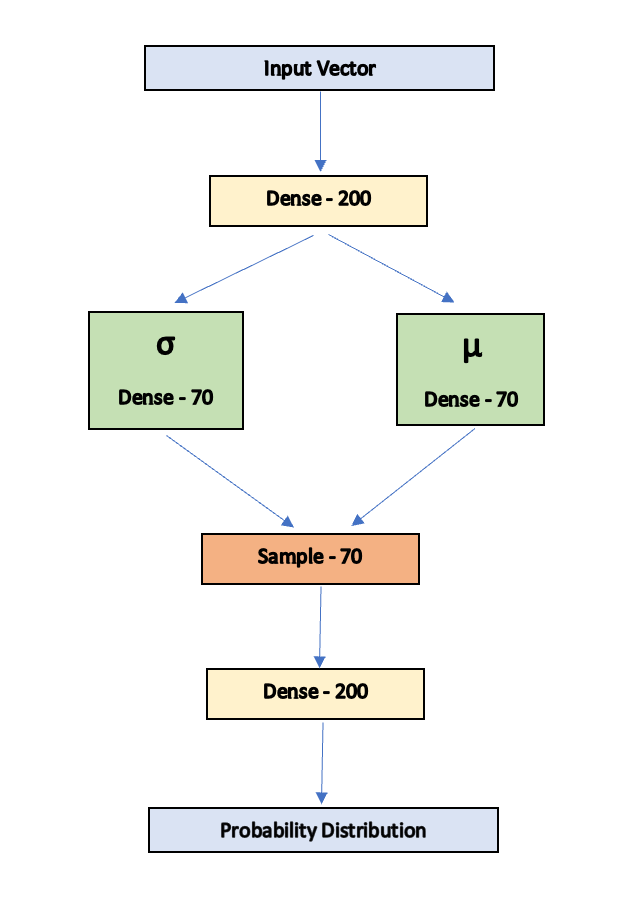

## 4.1 Standard VAE without annealing  (initial approach)

Firstly, we train Standard-VAE model using constant $\mathbf \beta$= 1.



In [131]:
model_without_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                   original_dim=train_data.shape[1], # Number of unique items in the training set
                                   intermediate_dim=INTERMEDIATE_DIM, 
                                   latent_dim=LATENT_DIM, 
                                   n_epochs=EPOCHS, 
                                   batch_size=BATCH_SIZE, 
                                   k=TOP_K,
                                   verbose=0,
                                   seed=SEED,
                                   save_path=WEIGHTS_PATH,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0
                                   )

In [132]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te_ratings, # with the original ratings 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Took 63.3621 seconds for training.


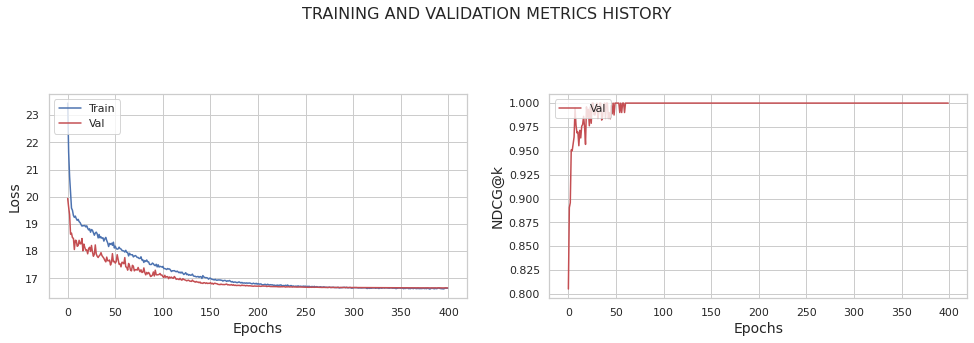

In [133]:
model_without_anneal.display_metrics() 

In [134]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using constant $\beta$ = 1.

Evaluate with recommending 5 items.

In [135]:
eval_k = 5
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_1:.5f}",
      f"NDCG@{eval_k}:\t\t{eval_ndcg_1:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_1:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_1:.5f}", sep='\n')

Took 0.3800 seconds for prediction.
MAP@5:		0.93629
NDCG@5:		0.95560
Precision@5:	0.39032
Recall@5: 	1.00000


Evaluate with recommending 10 items.

In [136]:
eval_k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_2:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_2:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_2:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_2:.5f}", sep='\n')

Took 0.0421 seconds for prediction.
MAP@10:		0.93952
NDCG@10:	0.95876
Precision@10:	0.19516
Recall@10: 	1.00000


## 4.2 Standard VAE with annealing 
We are going to use annealing procedure for finding the optimal $\mathbf \beta$.

Now, in order to find the optimal $\beta$, we train our model using annealing with anneal_cap equal 1.0.






In [137]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0)

In [138]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 70.7923 seconds for training.


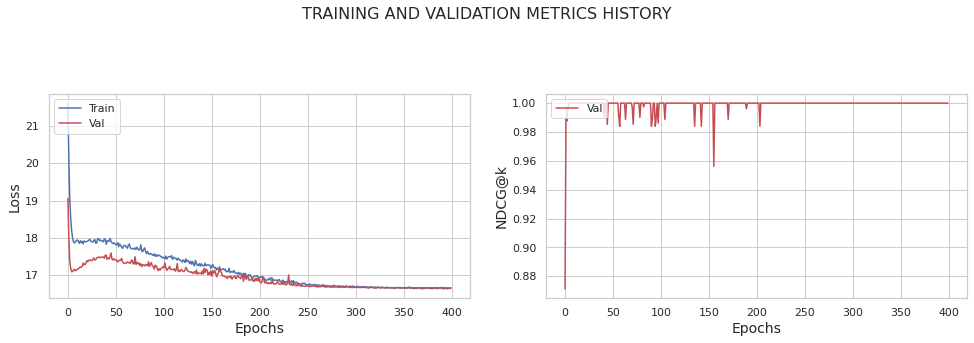

In [139]:
model_with_anneal.display_metrics()

In [140]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [141]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.015625


In [142]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [143]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 70.7953 seconds for training.


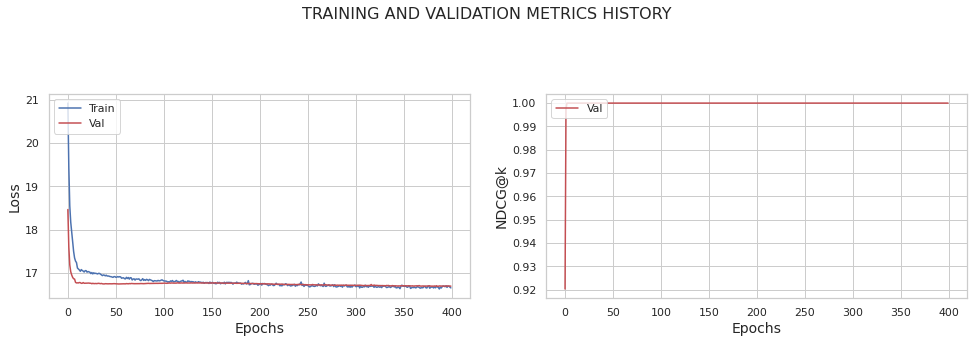

In [144]:
 model_optimal_beta.display_metrics()

In [145]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [146]:
eval_k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.0434 seconds for prediction.
MAP@10:		0.97312
NDCG@10:	0.98034
Precision@10:	0.19516
Recall@10: 	1.00000


Evaluate with recommending 10 items.

In [147]:
eval_k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_4 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_4 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_4 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_4 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)

print(f"MAP@{eval_k}:\t\t{eval_map_4:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_4:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_4:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_4:.5f}", sep='\n')

Took 0.0401 seconds for prediction.
MAP@10:		0.96640
NDCG@10:	0.97551
Precision@10:	0.19516
Recall@10: 	1.00000


# 5 Conclusion 

Through this notebook, it is proven that the VAE using annealing outperforms the model without annealing (using $\mathbf \beta$=1). Specifically, the results of evaluting the test set, for the the 2 different approaches, are:

| Model | NDCG@100  |NDCG@10 | 
| --- | --- | --- | 
| Standard-VAE (wihtout annealing, β=1)| 0.392 | 0.446 |
| Standard-VAE (with annealing, optimal β)| 0.443 | 0.496 | 


This annealing procedure is used as an efficient way to tune the parameter $\mathbf \beta$. Otherwise, training multiple models using different values of $\mathbf \beta$ can be really time consuming. 

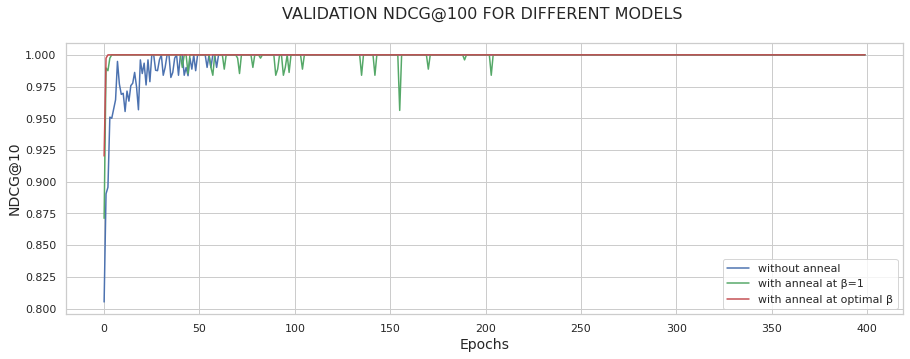

In [148]:
# Plot setup
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid')

# Plot NDCG@k of validation sets for three models
plt.plot(ndcg_val_without_anneal, color='b', linestyle='-', label='without anneal')
plt.plot(ndcg_val_with_anneal, color='g', linestyle='-', label='with anneal at β=1')
plt.plot(ndcg_val_optimal_beta, color='r', linestyle='-', label='with anneal at optimal β')

# Add plot title and axis names
plt.title('VALIDATION NDCG@100 FOR DIFFERENT MODELS \n', size=16)
plt.xlabel('Epochs', size=14)
plt.ylabel('NDCG@10', size=14)
plt.legend(loc='lower right')

plt.show()


# Now we are going to vary the Sparsity
We will be doing this by splitting the difference (i.e. 100% - ~75% = 25%) up in 5 equal steps of 5% each. This would result in 75%, 80%, 85%, 90% and 95% sparsity. At each step we will perform a full round of training, validating and testing to see the performance of the VAE under data sparseness.


In [149]:
def _print(message, verbose):
    if verbose:
        print(message)
    

def load_dataset(fp):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating", "timestamp"]] = pd.read_json(fp)[["reviewerID", "asin", "overall", "unixReviewTime"]]
    except:
        df = pd.read_json(fp)
    return df

def filter_on_minimal_ratings(df):
    # Divide into preferred and non-preferred/not-seen
    df_preferred = df[df['rating'] > 3.5]
    df_low_rating = df[df['rating'] <= 3.5]

    # Keep users who clicked on at least 5 movies
    df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

    # Keep movies that were clicked on by at least on 1 user
    df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")
    df.reset_index(drop=True, inplace=True)
    return df

def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df

def split_dataframe(df, val_percentage=0.1, test_percentage=0.2):
    unique_users = sorted(df.userID.unique())
    np.random.seed(SEED)
    unique_users = np.random.permutation(unique_users)
    
    # Create train/validation/test users 
    # The order of splitting is val, test and then training to solve the rounding error for int() on line 5, 6
    n_users = len(unique_users)
    print("Number of unique users:", n_users)
    HELDOUT_USERS_VAL = int(val_percentage * n_users)
    HELDOUT_USERS_TEST = int(test_percentage * n_users)

    val_users = unique_users[:HELDOUT_USERS_VAL]
    print("\nNumber of validation users:", len(val_users))

    test_users = unique_users[HELDOUT_USERS_VAL:(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST)]
    print("\nNumber of test users:", len(test_users))

    train_users = unique_users[(HELDOUT_USERS_VAL+HELDOUT_USERS_TEST):]
    print("\nNumber of training users:", len(train_users))
    
    # For training set keep only users that are in train_users list
    train_set = df.loc[df['userID'].isin(train_users)]
    print("Number of training observations: ", train_set.shape[0])

    # For validation set keep only users that are in val_users list
    val_set = df.loc[df['userID'].isin(val_users)]
    print("\nNumber of validation observations: ", val_set.shape[0])

    # For test set keep only users that are in test_users list
    test_set = df.loc[df['userID'].isin(test_users)]
    print("\nNumber of test observations: ", test_set.shape[0])

    # Obtain list of unique movies used in training set
    unique_train_items = pd.unique(train_set['itemID'])
    print("Number of unique items that rated in training set", unique_train_items.size)
    
    # For validation set keep only movies that used in training set
    val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
    print("Number of validation observations after filtering: ", val_set.shape[0])

    # For test set keep only movies that used in training set
    test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
    print("\nNumber of test observations after filtering: ", test_set.shape[0])
    return train_set, val_set, test_set
    
def create_click_matrix(train_set, val_set, test_set):
    # Instantiate the sparse matrix generation for train, validation and test sets
    # use list of unique items from training set for all sets
    unique_train_items = pd.unique(train_set['itemID'])
    am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)
    am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)
    am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)
    
    # Obtain the sparse matrix for train, validation and test sets
    train_data, _, _ = am_train.gen_affinity_matrix()
    print(train_data.shape)

    val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
    print(val_data.shape)

    test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
    print(test_data.shape)
    
    # Split validation and test data into training and testing parts
    val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
    test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)
    
    # Binarize train, validation and test data
    train_data = binarize(a=train_data, threshold=3.5)
    val_data = binarize(a=val_data, threshold=3.5)
    test_data = binarize(a=test_data, threshold=3.5)
    
    # Binarize validation data: training part  
    val_data_tr = binarize(a=val_data_tr, threshold=3.5)

    # Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
    val_data_te_ratings = val_data_te.copy()
    val_data_te = binarize(a=val_data_te, threshold=3.5)
    
    # Binarize test data: training part 
    test_data_tr = binarize(a=test_data_tr, threshold=3.5)

    # Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
    test_data_te_ratings = test_data_te.copy()
    test_data_te = binarize(a=test_data_te, threshold=3.5)
    
    # retrieve real ratings from initial dataset 
    test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
    val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

    for index,i in df_low_rating.iterrows():
        user_old= i['userID'] # old value 
        item_old=i['itemID'] # old value 

        if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
            user_new=test_map_users.get(user_old) # new value 
            item_new=test_map_items.get(item_old) # new value 
            rating=i['rating'] 
            test_data_te_ratings.at[user_new,item_new]= rating   

        if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
            user_new=val_map_users.get(user_old) # new value 
            item_new=val_map_items.get(item_old) # new value 
            rating=i['rating'] 
            val_data_te_ratings.at[user_new,item_new]= rating   


    val_data_te_ratings=val_data_te_ratings.to_numpy()    
    test_data_te_ratings=test_data_te_ratings.to_numpy()
    return train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings 
    

def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    df = filter_on_minimal_ratings(df)
    df = filter_to_sparsity(df, sparsity_percentage)
    train_set, val_set, test_set = split_dataframe(df)
    train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = create_click_matrix(train_set, val_set, test_set)
    return train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings


data_loading_pipeline("../data/AMAZON_FASHION_5.json", 0.75)

To obtain a sparsity of 75.0% we need to drop 374 ratings
Number of unique users: 329

Number of validation users: 32

Number of test users: 65

Number of training users: 232
Number of training observations:  1588

Number of validation observations:  210

Number of test observations:  451
Number of unique items that rated in training set 22
Number of validation observations after filtering:  209

Number of test observations after filtering:  440
(232, 22)
(32, 22)
(63, 22)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0.],
  

In [150]:
metrics_at_sparsity_levels = dict()

### Training with 75% sparsity

In [151]:
sparsity_percentage = 0.75

In [152]:
train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = data_loading_pipeline("../data/AMAZON_FASHION_5.json", sparsity_percentage)

To obtain a sparsity of 75.0% we need to drop 374 ratings
Number of unique users: 329

Number of validation users: 32

Number of test users: 65

Number of training users: 232
Number of training observations:  1581

Number of validation observations:  214

Number of test observations:  452
Number of unique items that rated in training set 22
Number of validation observations after filtering:  213

Number of test observations after filtering:  441
(232, 22)
(32, 22)
(63, 22)


In [153]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0)

In [154]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 72.3004 seconds for training.


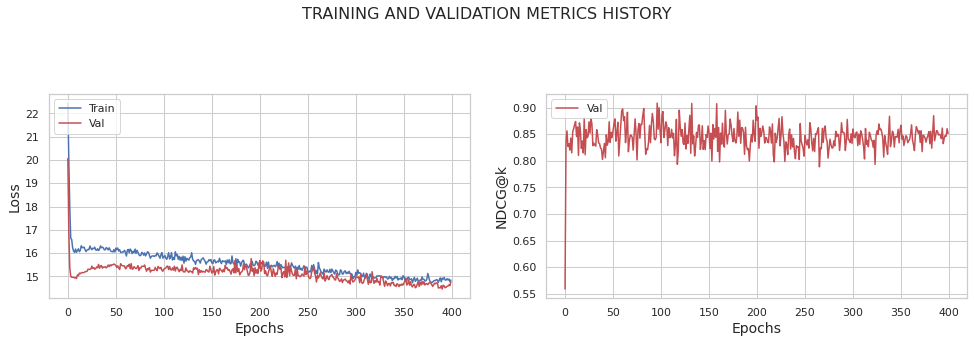

In [155]:
model_with_anneal.display_metrics()

In [156]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [157]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.303125


In [158]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [159]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 72.6269 seconds for training.


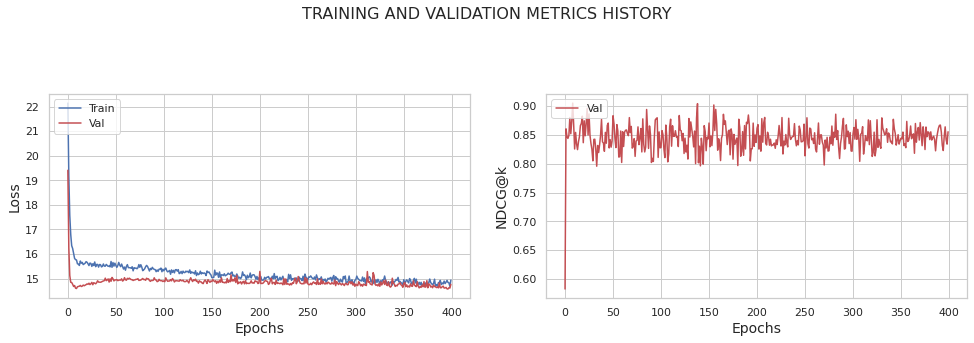

In [160]:
 model_optimal_beta.display_metrics()

In [161]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [162]:
test_data_tr.shape

(63, 22)

In [163]:
eval_k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {"map": eval_map_3,
                                                        "ndcg": eval_ndcg_3,
                                                        "precision": eval_precision_3,
                                                        "recall": eval_recall_3}

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.5284 seconds for prediction.
MAP@10:		0.76747
NDCG@10:	0.83841
Precision@10:	0.19032
Recall@10: 	0.98387


### Training with 80% sparsity

In [164]:
sparsity_percentage = 0.80

In [165]:
train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = data_loading_pipeline("../data/AMAZON_FASHION_5.json", sparsity_percentage)

To obtain a sparsity of 80.0% we need to drop 818 ratings
Number of unique users: 329

Number of validation users: 32

Number of test users: 65

Number of training users: 232
Number of training observations:  1339

Number of validation observations:  177

Number of test observations:  378
Number of unique items that rated in training set 22
Number of validation observations after filtering:  177

Number of test observations after filtering:  368
(232, 22)
(32, 22)
(63, 22)


In [166]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0)

In [167]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 76.3162 seconds for training.


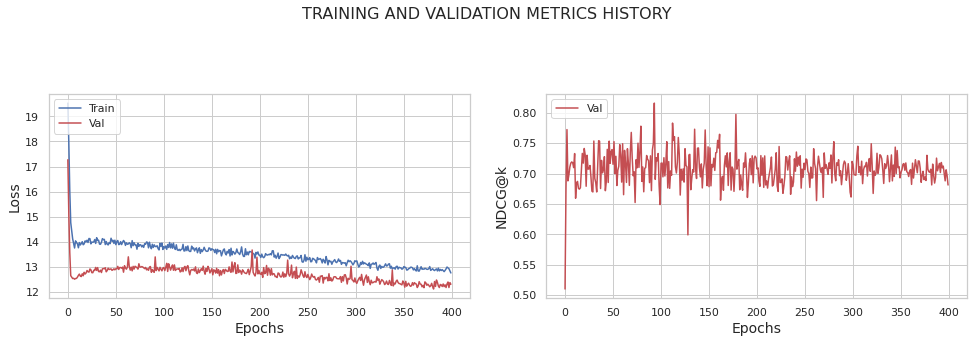

In [168]:
model_with_anneal.display_metrics()

In [169]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [170]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.29375


In [171]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [172]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 82.6700 seconds for training.


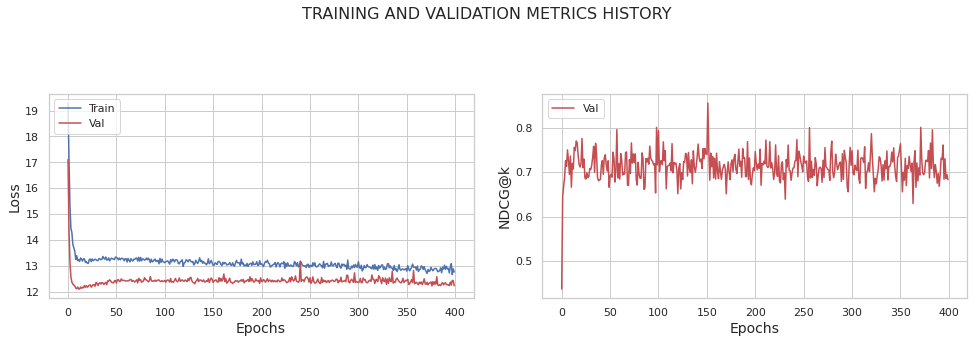

In [173]:
 model_optimal_beta.display_metrics()

In [174]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [175]:
eval_k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {"map": eval_map_3,
                                                        "ndcg": eval_ndcg_3,
                                                        "precision": eval_precision_3,
                                                        "recall": eval_recall_3}

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.6951 seconds for prediction.
MAP@10:		0.68806
NDCG@10:	0.77833
Precision@10:	0.16000
Recall@10: 	1.00000


### Training with 85% sparsity

In [176]:
sparsity_percentage = 0.85

In [177]:
train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = data_loading_pipeline("../data/AMAZON_FASHION_5.json", sparsity_percentage)

To obtain a sparsity of 85.0% we need to drop 1262 ratings
Number of unique users: 329

Number of validation users: 32

Number of test users: 65

Number of training users: 232
Number of training observations:  1114

Number of validation observations:  149

Number of test observations:  326
Number of unique items that rated in training set 21
Number of validation observations after filtering:  149

Number of test observations after filtering:  318
(232, 21)
(32, 21)
(63, 21)


In [178]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0)

In [179]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 84.6688 seconds for training.


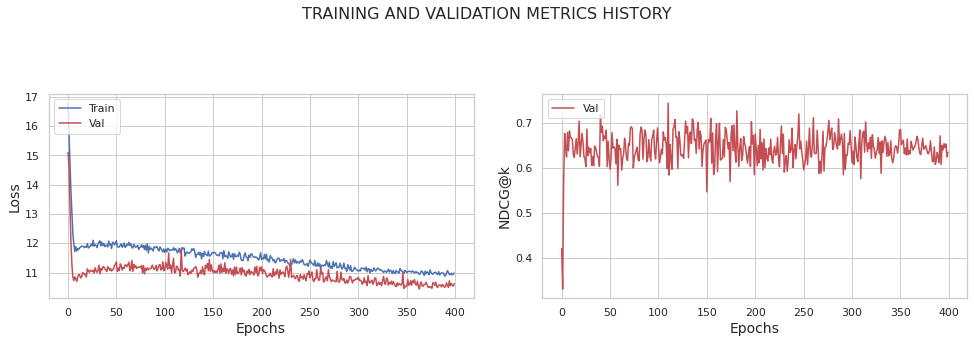

In [180]:
model_with_anneal.display_metrics()

In [181]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [182]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.346875


In [183]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [184]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 85.9203 seconds for training.


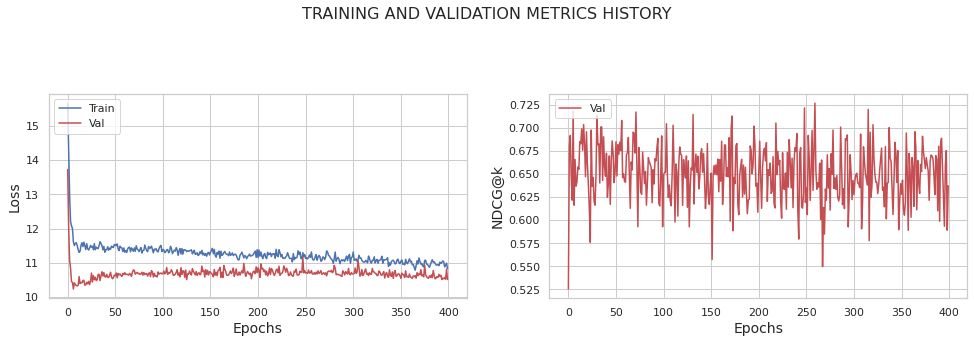

In [185]:
 model_optimal_beta.display_metrics()

In [186]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [187]:
eval_k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {"map": eval_map_3,
                                                        "ndcg": eval_ndcg_3,
                                                        "precision": eval_precision_3,
                                                        "recall": eval_recall_3}

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.6216 seconds for prediction.
MAP@10:		0.57500
NDCG@10:	0.68752
Precision@10:	0.13667
Recall@10: 	1.00000


### Training with 90% sparsity

In [188]:
sparsity_percentage = 0.90

In [191]:
train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = data_loading_pipeline("../data/AMAZON_FASHION_5.json", 0.90)

To obtain a sparsity of 90.0% we need to drop 1706 ratings
Number of unique users: 328

Number of validation users: 32

Number of test users: 65

Number of training users: 231
Number of training observations:  928

Number of validation observations:  128

Number of test observations:  279
Number of unique items that rated in training set 20
Number of validation observations after filtering:  128

Number of test observations after filtering:  272
(231, 20)
(32, 20)
(63, 20)


In [192]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0)

In [193]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 81.3655 seconds for training.


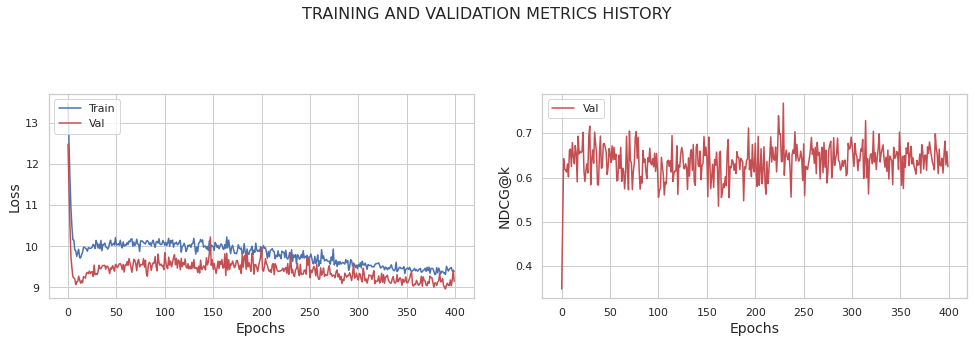

In [194]:
model_with_anneal.display_metrics()

In [195]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [196]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.71875


In [197]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [198]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 81.3120 seconds for training.


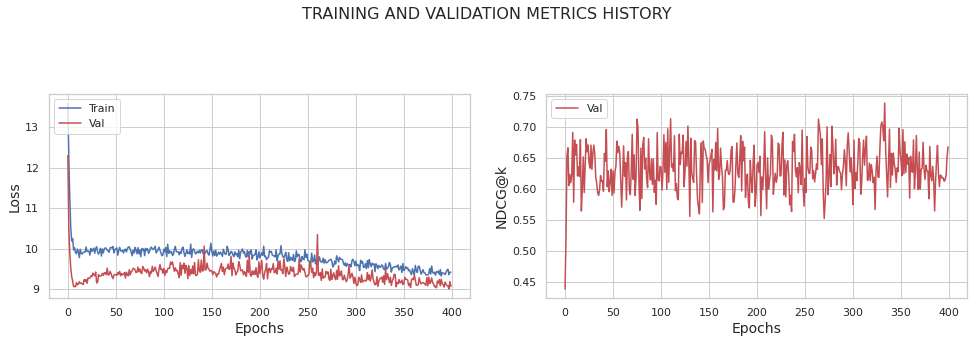

In [199]:
 model_optimal_beta.display_metrics()

In [200]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [201]:
eval_k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {"map": eval_map_3,
                                                        "ndcg": eval_ndcg_3,
                                                        "precision": eval_precision_3,
                                                        "recall": eval_recall_3}

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.7390 seconds for prediction.
MAP@10:		0.55690
NDCG@10:	0.67176
Precision@10:	0.11724
Recall@10: 	1.00000


### Training with 95% sparsity

In [202]:
sparsity_percentage = 0.95

In [203]:
train_data, am_val, val_data, val_data_tr, val_data_te_ratings, am_test, test_data, test_data_tr, test_data_te_ratings = data_loading_pipeline("../data/AMAZON_FASHION_5.json", 0.95)

To obtain a sparsity of 95.0% we need to drop 2150 ratings
Number of unique users: 324

Number of validation users: 32

Number of test users: 64

Number of training users: 228
Number of training observations:  794

Number of validation observations:  109

Number of test observations:  223
Number of unique items that rated in training set 22
Number of validation observations after filtering:  109

Number of test observations after filtering:  223
(228, 22)
(32, 22)
(64, 22)


In [204]:
model_with_anneal = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=True,
                                anneal_cap=1.0)

In [205]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te_ratings, #  with the original ratings
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 80.2715 seconds for training.


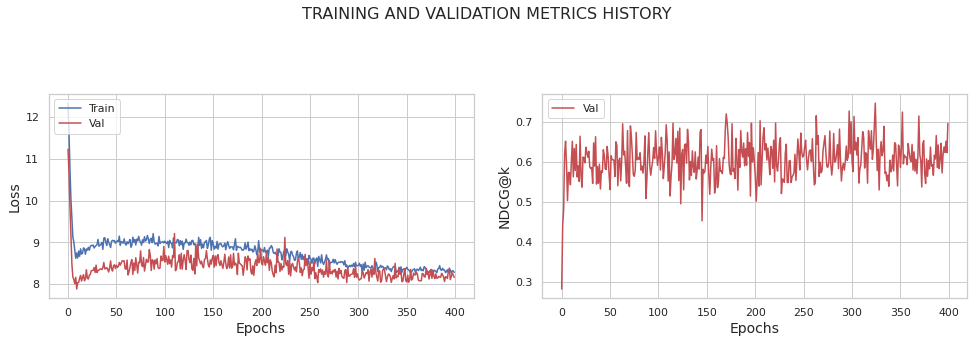

In [206]:
model_with_anneal.display_metrics()

In [207]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [208]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  1.0


In [209]:
model_optimal_beta = StandardVAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                 original_dim=train_data.shape[1], # Number of unique items in the training set
                                 intermediate_dim=INTERMEDIATE_DIM,
                                 latent_dim=LATENT_DIM,
                                 n_epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 k=TOP_K,  
                                 verbose=0,
                                 seed=SEED,
                                 save_path=WEIGHTS_PATH,
                                 drop_encoder=0.5,
                                 drop_decoder=0.5,
                                 annealing=True,
                                 anneal_cap=optimal_beta,  
                                 )

In [210]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te_ratings, # with the original ratings
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 83.0195 seconds for training.


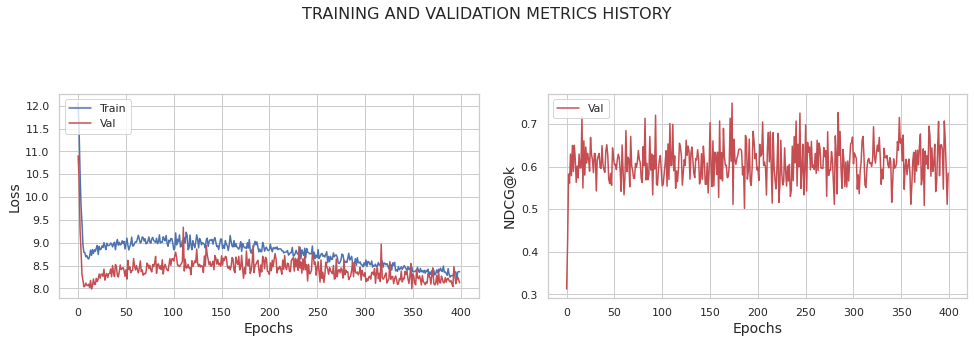

In [211]:
 model_optimal_beta.display_metrics()

In [212]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal $\beta$ with annealing.

Evaluate with recommending 10 items.

In [213]:
eval_k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                    k=eval_k,
                                                    remove_seen=True)
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=eval_k)
metrics_at_sparsity_levels[str(sparsity_percentage)] = {"map": eval_map_3,
                                                        "ndcg": eval_ndcg_3,
                                                        "precision": eval_precision_3,
                                                        "recall": eval_recall_3}

print(f"MAP@{eval_k}:\t\t{eval_map_3:.5f}",
      f"NDCG@{eval_k}:\t{eval_ndcg_3:.5f}",
      f"Precision@{eval_k}:\t{eval_precision_3:.5f}",
      f"Recall@{eval_k}: \t{eval_recall_3:.5f}", sep='\n')

Took 0.9524 seconds for prediction.
MAP@10:		0.45128
NDCG@10:	0.58717
Precision@10:	0.10769
Recall@10: 	1.00000


# Plotting metrics over Sparsity

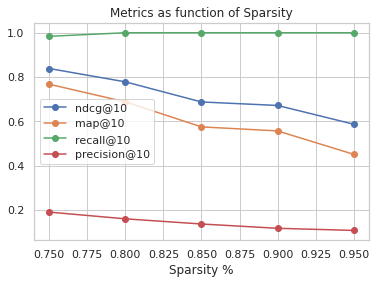

In [214]:
sparsity_levels = list(map(lambda x: float(x), metrics_at_sparsity_levels))
plt.plot(sparsity_levels, list(map(lambda x: x['ndcg'], metrics_at_sparsity_levels.values())), label="ndcg@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['map'], metrics_at_sparsity_levels.values())), label="map@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['recall'], metrics_at_sparsity_levels.values())), label="recall@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['precision'], metrics_at_sparsity_levels.values())), label="precision@10", marker = "o")
plt.title("Metrics as function of Sparsity")
plt.xlabel("Sparsity %")
plt.legend()
plt.show()

# 6 References

[Liang, Dawen, et al, 2018] [Liang, Dawen, et al. "Variational autoencoders for collaborative filtering." Proceedings of the 2018 World Wide Web Conference. 2018.](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o) 

[Kingma et al, 2013] [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."  (2013).](https://arxiv.org/pdf/1312.6114.pdf)

[Burgess et al, 2018] [Burgess, Christopher P., et al. "Understanding disentangling in $\beta $-VAE." (2018)](https://arxiv.org/pdf/1804.03599.pdf)

[Higgins et al, 2016] [Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." (2016).](https://openreview.net/pdf?id=Sy2fzU9gl)


[Bowman et al, 2015] [Samuel R. Bowman, Luke Vilnis, Oriol Vinyals, Andrew M. Dai, Rafal Jozefowicz,
and Samy Bengio. 2015. Generating sentences from a continuous space. (2015).](https://arxiv.org/pdf/1511.06349.pdf)
